In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import sqlite3

# Importing Data

In [16]:
import logging

logging.basicConfig(
    filename='data_processing.log',
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

In [17]:
def correct_email(row):
    return row['email'].lower()


def read_users_table(filename):
    try:
        users_df = pd.read_csv(filename)

        logger.info(f"Starting processing for {len(users_df.index)} records in the file {filename}.")

        users_df['email'] = users_df.apply(lambda row: correct_email(row), axis=1)
        users_df['date_joined'] = users_df.apply(lambda row: pd.to_datetime(row['date_joined'], errors='coerce'), axis=1)
        users_df['date_joined'] = users_df['date_joined'].apply(lambda x: x if not pd.isna(x) else pd.NA)
        users_df['user_id'] = pd.to_numeric(users_df['user_id'], errors='coerce', downcast='integer')
        users_df['user_id'] = users_df['user_id'].astype(int)
        users_df = users_df.drop_duplicates(subset=['user_id'], keep='first')
        users_df = users_df.dropna()
        return users_df
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None
users_df = read_users_table('users-1.csv')
users_df

,user_id,name,email,date_joined
0,1,John Doe,johndoe@email.com,2022-01-01
1,2,Jane Smith,janesmith@email.com,2022-01-05
2,3,Robert Brown,robertbrown@email.net,2022-01-10
3,4,Lucy Gray,lucy.gray@email.com,2022-02-01
4,5,Michael Green,mgreen@email.org,2022-02-15
5,7,Lucy Gray,lucy.gray@email.com,2022-02-01


In [18]:
def correct_product(row, pricing_df):
    if row['product'].upper() in pricing_df['product'].str.upper().values:
        return row['product'].upper()
    else:
        return pd.NA


def read_pricing_table(filename):
    try:
        pricing_df = pd.read_csv('pricing-1.csv')

        logger.info(f"Starting processing for {len(pricing_df.index)} records in the file {filename}.")

        pricing_df = pricing_df.drop_duplicates(subset=['product'], keep='first')

        pricing_df['product'] = pricing_df.apply(lambda row: correct_product(row, pricing_df), axis=1)
        pricing_df['price'] = pd.to_numeric(pricing_df['price'], errors='coerce')
        pricing_df['puk'] = pd.to_numeric(pricing_df['puk'], errors='coerce', downcast='integer')

        pricing_df = pricing_df.dropna()
        return pricing_df
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None
    
pricing_df = read_pricing_table('pricing-1.csv')
pricing_df

,puk,product,price
0,72527273070,SAMSUNG TV,599
1,72527273071,IPAD,499
2,72527273072,MACBOOK,1299
3,72527273073,IPHONE,999
5,72527273075,KINDLE,89
6,72527273076,KINDLE2,89
7,72527273078,KINDLE4,89
8,72527273079,KINDLE5,89


In [19]:



def is_valid_date(value):
    if pd.isna(value) or isinstance(value, int) or isinstance(value, np.float64) or isinstance(value, np.int64) or isinstance(value, float):
        return False
    try:
        date = pd.to_datetime(value, errors='raise')
        return True
    except (ValueError, TypeError):
        pass
    return False

def correct_trans_date(row):
    # Check if trans_date is NaN
    if pd.isna(row['trans_date']):
        # iterate through other columns to find a valid date
        for col in row.index:
            if col != 'trans_date' and is_valid_date(row[col]):
                return pd.to_datetime(row[col])
        return pd.NaT  # return NaT if no valid date is found
    elif not is_valid_date(row['trans_date']):
        return pd.NaT
    return pd.to_datetime(row['trans_date'])

    
def correct_product(row, pricing_df):
    if row['product'].upper() in pricing_df['product'].str.upper().values:
        return row['product'].upper()
    else:
        return pd.NA

def correct_amount(row, pricing_df):
    cost = pricing_df.loc[pricing_df['product'].str.upper() == row['product'], 'price']
    if len(cost) == 1:
        return cost.values[0]
    else:
        return pd.NA
    
def read_transactions_table(filename):
    try:
        df = pd.read_csv(filename)
        logger.info(f"Starting processing for {len(df.index)} records in the file {filename}.")
        df['trans_date'] = df.apply(correct_trans_date, axis=1)
        df['trans_id'] = pd.to_numeric(df['trans_id'], errors='coerce', downcast='integer')
        df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce', downcast='integer')
        df['product'] = df.apply(lambda row: correct_product(row, pricing_df), axis=1)
        df['amount'] = df.apply(lambda row: correct_amount(row, pricing_df), axis=1)

        df = df.dropna()
        df = df.drop_duplicates(subset=['trans_id'], keep='first')

        df['trans_id'] = df['trans_id'].astype(int)
        df['user_id'] = df['user_id'].astype(int)
        df['amount'] = df['amount'].astype(float)

        df['trans_date'] = df['trans_date'].dt.strftime('%Y-%m-%d')
        df['trans_date'] = df.apply(lambda row: pd.to_datetime(row['trans_date'], errors='coerce'), axis=1)
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None

    return df

df = read_transactions_table('transactions-1.csv')
df

,trans_id,user_id,product,amount,trans_date
0,1014,1,SAMSUNG TV,599.0,2022-04-01
1,1015,2,IPAD,499.0,2022-04-05
2,1016,3,MACBOOK,1299.0,2022-04-10
3,1017,4,IPHONE,999.0,2022-04-15
4,1018,5,SAMSUNG TV,599.0,2022-04-20
...,...,...,...,...,...
81,1095,3,IPAD,499.0,2024-05-18
82,1096,4,MACBOOK,1299.0,2024-06-01
83,1097,5,IPHONE,999.0,2024-06-15
84,1198,5,IPHONE,999.0,2024-06-15


In [20]:
def add_total_spent(row, df):
        amounts = df.loc[df['user_id'] == row['user_id'], 'amount']
        if len(amounts) >= 0:
            return df.loc[df['user_id'] == row['user_id'], 'amount'].sum()
        else:
            return pd.NA
try:
    logger.info(f"Adding new column inside users.csv with {len((users_df))} rows for total amount of money spent for each user.")
    users_df['total_spent'] = users_df.apply(lambda row: add_total_spent(row, df), axis=1)
except Exception as e:
    logger.error(f"Error processing data: {e}")
users_df

,user_id,name,email,date_joined,total_spent
0,1,John Doe,johndoe@email.com,2022-01-01,7165.0
1,2,Jane Smith,janesmith@email.com,2022-01-05,10585.0
2,3,Robert Brown,robertbrown@email.net,2022-01-10,14486.0
3,4,Lucy Gray,lucy.gray@email.com,2022-02-01,14586.0
4,5,Michael Green,mgreen@email.org,2022-02-15,5485.0
5,7,Lucy Gray,lucy.gray@email.com,2022-02-01,1587.0


# Transfer to SQLite

In [21]:


def check_if_table_exists(table_name):
    logger.info(f"Checking if {table_name} exist in my_database.db.")
    try:
        conn = sqlite3.connect('my_database.db')
        cur = conn.cursor()

        query = f"SELECT name FROM sqlite_master WHERE type='table' and name = '{table_name}'"
        res = cur.execute(query).fetchall()
        conn.close()
        logger.info(f"{res} are found in my_database.db")
        return len(res) > 0
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None
    


def check_existing_tables():
    try:
        conn = sqlite3.connect('my_database.db')
        cur = conn.cursor()

        query = f"SELECT name FROM sqlite_master WHERE type='table'"
        res = cur.execute(query).fetchall()
        conn.close()
        logger.info(f"Checking existing tables in my_database.db and found {res}")
        return res
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None


def update_table(df, table_name, primary_key_name):
    try:
        conn = sqlite3.connect('my_database.db')
        cur = conn.cursor()

        existing_ids = pd.read_sql_query(f'SELECT {primary_key_name} FROM {table_name}', conn)
        existing_ids = set(existing_ids[primary_key_name])

        #check news rows in dataframe then insert to sqlite
        df_new = df[~df[primary_key_name].isin(existing_ids)]   
        string_df_new='\t'+ df_new.to_string().replace('\n', '\n\t')
        logging.info(f'inserted {string_df_new} in {table_name} sqlite.') 

        df_new.to_sql(table_name, conn, if_exists='append', index=False)
        
        #get the diff of shrinked df and sqlite df
        new_ids = set(df[primary_key_name])
        ids_to_delete = existing_ids - new_ids

        logging.info(f'Deleted row ID {ids_to_delete} in {table_name} sqlite.') 
        if len(ids_to_delete) > 0:
            ids_to_delete_str = ','.join(map(str, ids_to_delete))

            ids_to_be_deleted = pd.read_sql_query(f'SELECT {primary_key_name} FROM {table_name} WHERE {primary_key_name} IN ({ids_to_delete_str})', conn)
            string_ids_to_be_deleted='\t'+ ids_to_be_deleted.to_string().replace('\n', '\n\t')
            logging.info(f'Deleted row {string_ids_to_be_deleted} in {table_name} sqlite.') 
            
            conn.execute(f"""
            DELETE FROM {table_name}
            WHERE {primary_key_name} IN ({ids_to_delete_str})
            """)
            conn.commit()

        conn.close()
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None

def create_table(df, table_name, query):
    try:
        conn = sqlite3.connect('my_database.db')
        cur = conn.cursor()
        cur.execute(query)
        logging.info(f'new table {table_name} is created and inserting {len(df.index)} rows') 
        df.to_sql(table_name, conn, if_exists='append', index=False)
        conn.close()
    except Exception as e:
        logger.error(f"Error processing data: {e}")
        return None

In [22]:
def add_to_sqlite(df, table_name, query, primary_key_name):
    if check_if_table_exists(table_name):
        update_table(df, table_name, primary_key_name)
    else:
        create_table(df, table_name, query)

query = """
        CREATE TABLE IF NOT EXISTS transactions (
            trans_id INTEGER PRIMARY KEY,
            user_id INTEGER,
            product TEXT,
            amount REAL,
            trans_date TEXT,
            FOREIGN KEY (user_id) REFERENCES users(user_id),
            FOREIGN KEY (product) REFERENCES pricing(product)
        );        
        """
table_name = 'transactions'
primary_key_name = 'trans_id'
df = read_transactions_table('transactions-1.csv')
add_to_sqlite(df, table_name, query, primary_key_name)

query = """
    CREATE TABLE IF NOT EXISTS pricing (
        puk INTEGER PRIMARY KEY,
        product TEXT UNIQUE,
        price REAL
    );        
    """
table_name = 'pricing'
primary_key_name = 'puk'
df = read_pricing_table('pricing-1.csv')
add_to_sqlite(df, table_name, query, primary_key_name)

query = """
    CREATE TABLE IF NOT EXISTS users (
        user_id INTEGER PRIMARY KEY,
        name TEXT,
        email TEXT,
        date_joined TEXT,
        total_spent REAL
    );        
    """
table_name = 'users'
primary_key_name = 'user_id'
df = read_users_table('users-1.csv')
add_to_sqlite(df, table_name, query, primary_key_name)

In [23]:
conn = sqlite3.connect('my_database.db')

cur = conn.cursor()
res = cur.execute("""
    select * from pricing
""")
print(res.fetchall())
conn.close()

[(72527273070, 'SAMSUNG TV', 599.0), (72527273071, 'IPAD', 499.0), (72527273072, 'MACBOOK', 1299.0), (72527273073, 'IPHONE', 999.0), (72527273075, 'KINDLE', 89.0), (72527273076, 'KINDLE2', 89.0), (72527273078, 'KINDLE4', 89.0), (72527273079, 'KINDLE5', 89.0)]


# Basic Analysis 

### Calculate the total amount spent by each user.

In [24]:
def add_user_names(row, users_df):
    user_name = users_df.loc[users_df['user_id'] == row['user_id'], 'name' ]
    if len(user_name) == 1:
        return user_name.values[0]
    else:
        return pd.NA

Text(0.5, 1.0, 'Total Amount Spent by Each User')

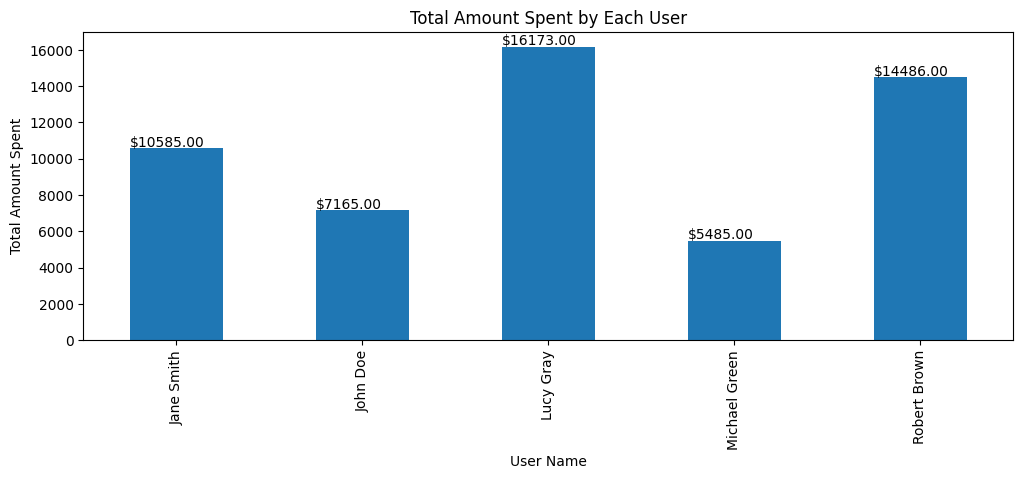

In [26]:
fig, axs = plt.subplots(figsize=(12, 4))

df = read_transactions_table('transactions-1.csv')
df_plotting = df.copy()
df_plotting['user_name'] = df_plotting.apply(lambda x: add_user_names(x, users_df), axis=1)


grouped_df = df_plotting.groupby("user_name")["amount"].sum()

ax = grouped_df.plot(
    kind='bar', rot=90, ax=axs
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}', (p.get_x(), height+100))


plt.xlabel("User Name")
plt.ylabel("Total Amount Spent")
plt.title("Total Amount Spent by Each User")


Lucy Gray spent the most amount of money.

Text(0.5, 1.0, 'Total Amount Spent by Each User ID')

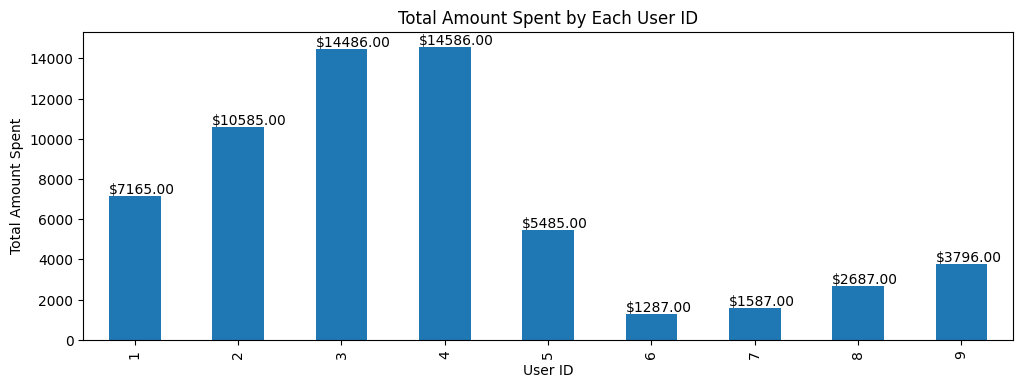

In [27]:
fig, axs = plt.subplots(figsize=(12, 4))

grouped_df = df_plotting.groupby("user_id")["amount"].sum()
ax = grouped_df.plot(
    kind='bar', rot=90, ax=axs
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}', (p.get_x(), height+100))


plt.xlabel("User ID")
plt.ylabel("Total Amount Spent")
plt.title("Total Amount Spent by Each User ID")


User 4 spent them most amount of money.

### General Description

In [28]:
print("data types for each column:")
print(df.dtypes)
print()

print("other description:")
print(df.describe())
print()

data types for each column:
trans_id               int32
user_id                int32
product               object
amount               float64
trans_date    datetime64[ns]
dtype: object

other description:
          trans_id    user_id       amount
count    86.000000  86.000000    86.000000
mean   1058.825581   3.686047   717.023256
std      32.418655   2.176136   409.354786
min    1014.000000   1.000000    89.000000
25%    1035.250000   2.000000   499.000000
50%    1056.500000   3.000000   599.000000
75%    1077.750000   5.000000   999.000000
max    1199.000000   9.000000  1299.000000



This is the general information of the transactions.csv data


### Transaction Trends

Text(0.5, 1.0, 'Total Amount Spent by Users per Month')

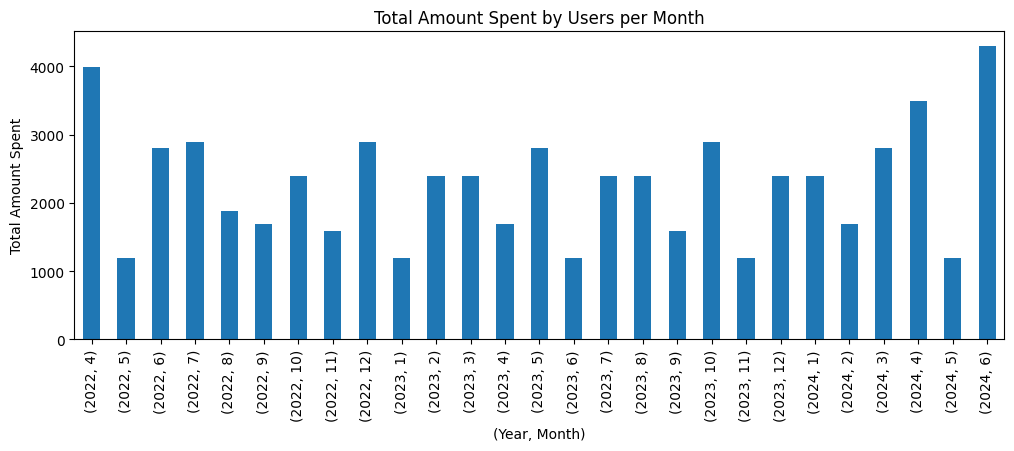

In [29]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby([df["trans_date"].dt.year, df["trans_date"].dt.month])["amount"].sum().plot(
    kind='bar', rot=90, ax=axs
)

plt.xlabel("(Year, Month)")
plt.ylabel("Total Amount Spent")
plt.title("Total Amount Spent by Users per Month")

The total amount of money spent is volatile per month. But it went downward from April 2022 to June 2023. Then, it went generally upwards from June 2023 toJune 2024.

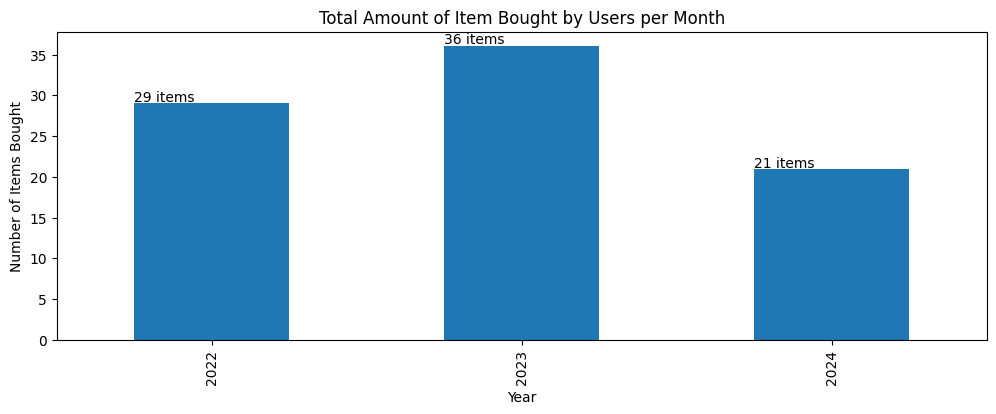

In [30]:
fig, axs = plt.subplots(figsize=(12, 4))
ax = df.groupby(df["trans_date"].dt.year)["amount"].count().plot(
    kind='bar', rot=90, ax=axs
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height} items', (p.get_x(), height* 1.01))

plt.xlabel("Year")
plt.ylabel("Number of Items Bought")
plt.title("Total Amount of Item Bought by Users per Month")




# Add annotations on top of each bar with the actual count

plt.show()

The year 2023 is the most amount of items sold.

Text(0.5, 1.0, 'Total Amount of Item Bought by Users per Month')

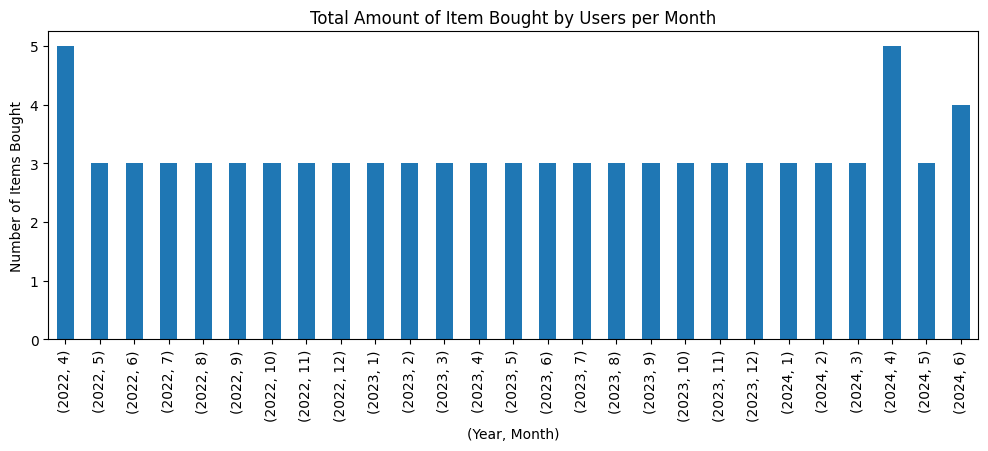

In [31]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby([df["trans_date"].dt.year, df["trans_date"].dt.month])["amount"].count().plot(
    kind='bar', rot=90, ax=axs
)
plt.xlabel("(Year, Month)")
plt.ylabel("Number of Items Bought")
plt.title("Total Amount of Item Bought by Users per Month")

The amount of items bought is very uniform.

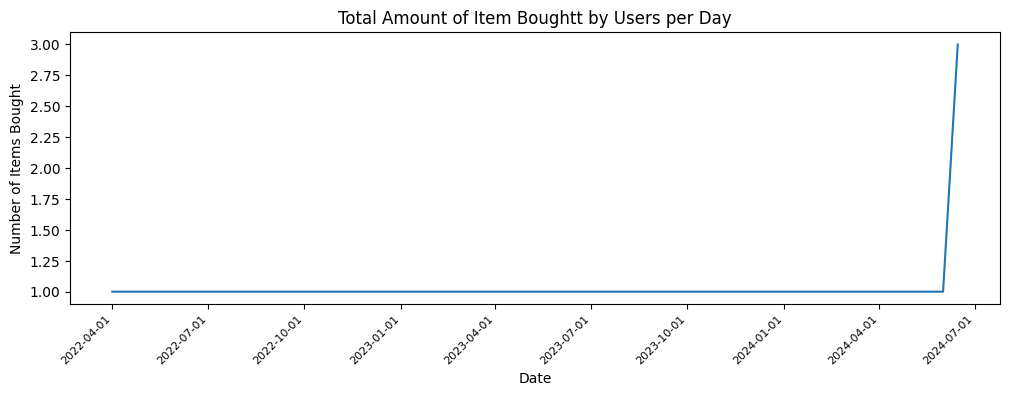

In [32]:
fig, axs = plt.subplots(figsize=(12, 4))
df.groupby([df["trans_date"]])["amount"].count().plot(
    kind='line', rot=45, ax=axs
)
plt.xlabel("Date")
plt.ylabel("Number of Items Bought")
plt.title("Total Amount of Item Boughtt by Users per Day")

plt.xticks(fontsize=8)
date_format = mdates.DateFormatter('%Y-%m-%d')
axs.xaxis.set_major_formatter(date_format)

The amount of items sold is very uniform until recently.

### User Behavior

In [33]:
df2 = df.sort_values(by=['user_id', 'trans_date'])
df2['time_gap'] = df2.groupby('user_id')['trans_date'].diff()

average_time_gap = df2.groupby('user_id')['time_gap'].mean().reset_index()
average_time_gap

,user_id,time_gap
0,1,54 days 10:17:08.571428571
1,2,55 days 05:08:34.285714286
2,3,59 days 03:41:32.307692308
3,4,59 days 20:18:27.692307692
4,5,56 days 05:08:34.285714286
5,6,314 days 12:00:00
6,7,286 days 00:00:00
7,8,250 days 00:00:00
8,9,163 days 08:00:00


User ID 1 is the most frequent buyer.